In [1]:
import numpy as np 
import scipy as sp
import pandas as pd 
import librosa 
import sklearn
import matplotlib.pyplot as plt 
from pathlib import Path 
import pathlib
from IPython.display import Audio,display
from tqdm import tqdm   


In [2]:
audio_dir:Path = Path("/home/pujan/D/projects/dsp/datasets/audio/")

In [3]:
audio_paths:list[pathlib.PosixPath]= [file for file in audio_dir.iterdir()]

##### Human voices are often less than 8k hz. so according to nyquist theorem, the sampling rate should be twice the maximum number of frequency present , hence :- 16k HZ is often enough for human audio analysis.

In [4]:
SAMPLING_RATE:int = 16000;

In [5]:
y:np.array;
sr:int;
y,sr = librosa.load(audio_paths[100],sr=SAMPLING_RATE);
y

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -1.9121170e-04,  2.9802322e-05,  1.4925003e-04],
      shape=(140160,), dtype=float32)

#### Lowcut :-	80 – 100 Hz	 //Removes low-frequency noise: mic hum (50/60 Hz), rumble, handling noise; keeps fundamental male voice frequencies
#### Highcut :-	3000 – 3500 Hz	//Removes high-frequency hiss, some background noise; preserves most speech intelligibility and clarity

In [6]:
#constansts

LOW_CUTOFF = 80 #HZ
HIGH_CUTOFF = 3000 #HZ
ORDER = 4 #order of the filter

Filter designed successfully.


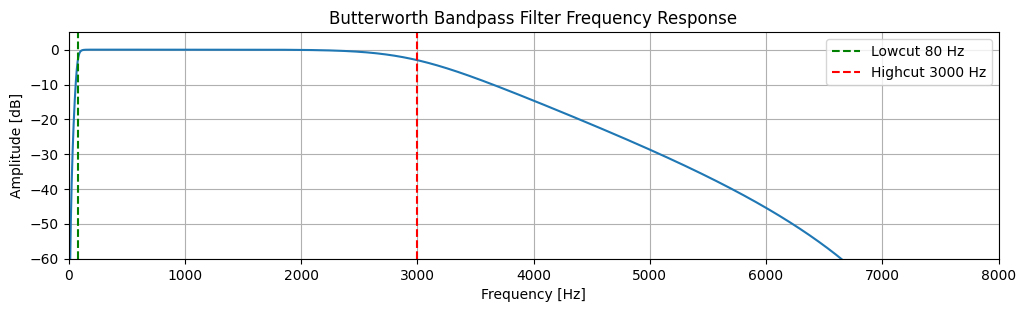

In [7]:
# Designing the Butterworth Bandpass Filter 
# 'fs' is the sampling frequency.
# 'btype' is 'band' for bandpass.
# 'output='sos'' is crucial for numerical stability.
sos = sp.signal.butter(ORDER, [LOW_CUTOFF, HIGH_CUTOFF], btype='band', analog=False, output='sos', fs=SAMPLING_RATE)
print("Filter designed successfully.")


w, h = sp.signal.sosfreqz(sos, worN=8000, fs=SAMPLING_RATE)

db = 20*np.log10(np.maximum(np.abs(h), 1e-5)) #db magnitube


#Plot the filter's frequency response
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(w,db) 
plt.title('Butterworth Bandpass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(True)
plt.axvline(LOW_CUTOFF, color='green', linestyle='--', label=f'Lowcut {LOW_CUTOFF} Hz')
plt.axvline(HIGH_CUTOFF, color='red', linestyle='--', label=f'Highcut {HIGH_CUTOFF} Hz')
plt.xlim(0, SAMPLING_RATE / 2)
plt.ylim(-60, 5)
plt.legend()
plt.show()

In [8]:
#. Applying the Filter to the Signal 
filtered_signal = sp.signal.sosfilt(sos,y)
print("Filter applied to the signal.")
filtered_signal

Filter applied to the signal.


array([0.        , 0.        , 0.        , ..., 0.00018559, 0.00052335,
       0.00088187], shape=(140160,))

In [9]:
print("Original Signal")
Audio(y,rate=SAMPLING_RATE)

Original Signal


In [10]:
print("Passband filtered signal(Butterworth)")
Audio(filtered_signal,rate=SAMPLING_RATE)

Passband filtered signal(Butterworth)


## Framing the signals

#### Framing in signal processing is the process of dividing a continuous signal into short, overlapping segments called frames.

#### **Why it's done:**

#### To analyze short-time features of non-stationary signals (like speech), since signals often change over time. Framing enables time-localized processing like Fourier transforms.

In [11]:
FRAME:int = int(0.025 * SAMPLING_RATE); #25 ms frame length 
HOP:int = int(0.01 * SAMPLING_RATE); #10 ms hop length i.e 15 ms striding 
FRAME,HOP

(400, 160)

In [12]:
FRAME = 512 #nearest power of 2 
HOP = 128 

In [13]:
def make_frame(x:np.array,frame:int,hop:int):

    frames:list[list] = [];
    for i in range(0,len(x),hop):
        end = i + frame;
        arr = x[i:end].tolist();
        
        if end==len(x):
            frames.append(arr);
            break;


        if len(arr) < frame:
            arr += [0] * (frame-len(arr));
            frames.append(arr);
            break;

        frames.append(arr);
    return frames;

In [14]:
frames_array:np.ndarray = np.array(make_frame(filtered_signal,FRAME,HOP),dtype=np.float32);

In [15]:
frames_array.shape

(1092, 512)

### Applying window technique such as hammming, hanning,kaiser,etc

we will apply hamming window here


In [17]:
hamming_window = sp.signal.windows.hamming(512) #since each frame is of size 400, so 400 size window 

windowed_data = frames_array * hamming_window;

In [18]:
fft = sp.fft.fft(windowed_data,axis=1);

fft.shape

(1092, 512)

In [19]:
mag_spectrum = np.abs(fft)

In [20]:
mag_spectrum = mag_spectrum[:, :mag_spectrum.shape[1] // 2]  #taking only positive values since the values are mirrored

In [21]:
mag_spectrum_db = 20 * np.log10(mag_spectrum + 1e-10)  # adding epsilon to avoid log(0)


In [22]:
mag_spectrum_db

array([[-200.        , -200.        , -200.        , ..., -200.        ,
        -200.        , -200.        ],
       [-200.        , -200.        , -200.        , ..., -200.        ,
        -200.        , -200.        ],
       [-200.        , -200.        , -200.        , ..., -200.        ,
        -200.        , -200.        ],
       ...,
       [ -60.40584575,  -56.54658068,  -46.00558859, ...,  -88.94998586,
         -88.95096644,  -88.95145797],
       [ -92.70275271,  -51.84537416,  -42.22187539, ...,  -92.18747817,
         -92.18835432,  -92.18891974],
       [ -60.83997128,  -50.99830969,  -35.63633088, ...,  -88.92494175,
         -88.92595942,  -88.92650065]], shape=(1092, 256))

In [23]:
frequencies = sp.fft.fftfreq(fft.shape[-1],1/SAMPLING_RATE)

In [24]:
frequencies = frequencies[:len(frequencies)//2]
frequencies.shape

(256,)

In [25]:
times = (np.arange(fft.shape[0]) * HOP)/SAMPLING_RATE
times[-1]

np.float64(8.728)

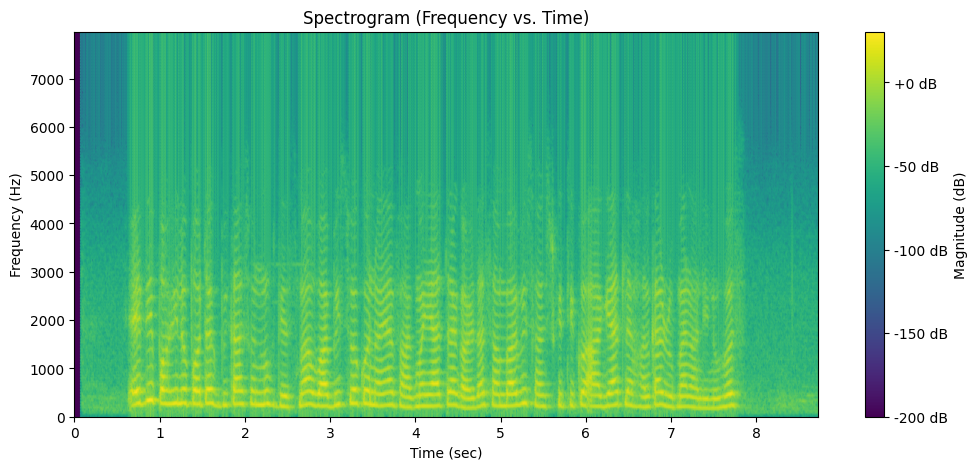

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
img = ax.pcolormesh(times, frequencies, mag_spectrum_db.T, shading='gouraud', cmap='viridis') 

# for pcolormesh() matplotlib expects the rows to be Y-axis (vertical) and columns to be X-axis (horizontal).
#So:
#Without transposing: pcolormesh(data) plots:
#X-axis → feature indices (columns)
#Y-axis → frame indices (rows)

fig.colorbar(img, ax=ax, format='%+2.0f dB', label='Magnitude (dB)')
ax.set_title('Spectrogram (Frequency vs. Time)')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (sec)')


plt.show()

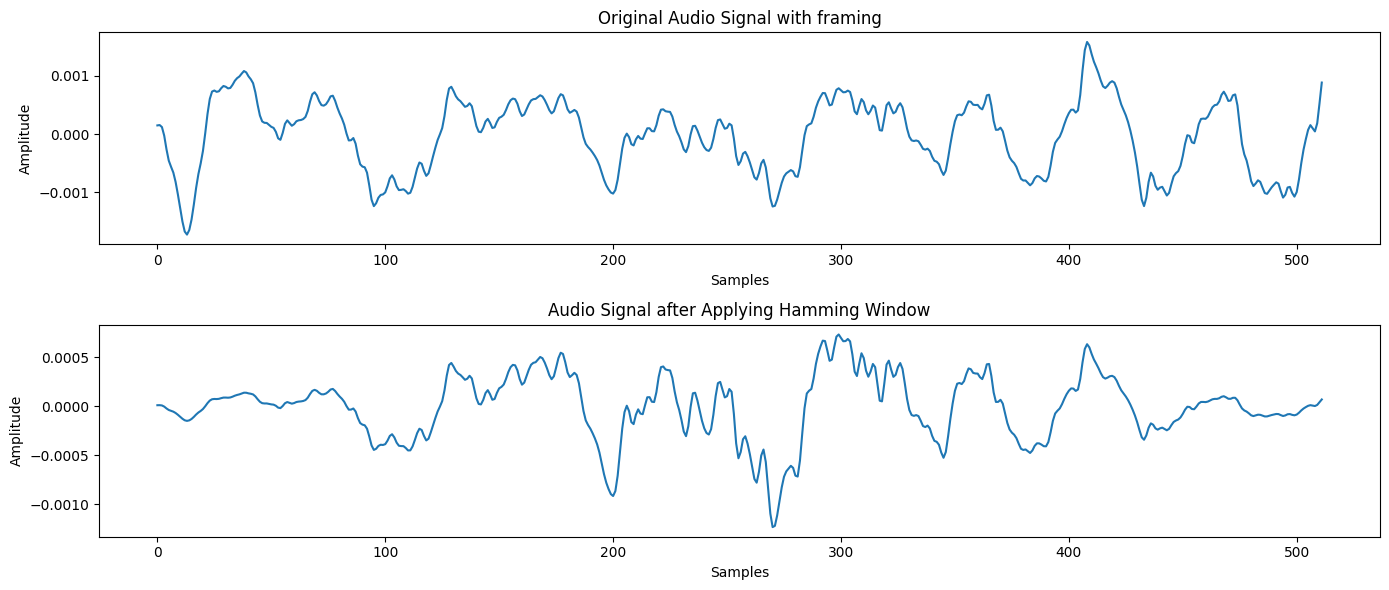

In [27]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.title('Original Audio Signal with framing')
plt.plot(frames_array[-1])
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.title('Audio Signal after Applying Hamming Window')
plt.plot(windowed_data[-1])
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [28]:
print("Original audio after framing")
Audio(frames_array[3:300].flatten(),rate=SAMPLING_RATE)

Original audio after framing


In [29]:
print("Hamming windowed Audio with framing")
Audio(windowed_data[3:300].flatten(),rate=SAMPLING_RATE)

Hamming windowed Audio with framing


In [30]:
centroid = librosa.feature.spectral_centroid(y=filtered_signal, sr=SAMPLING_RATE)

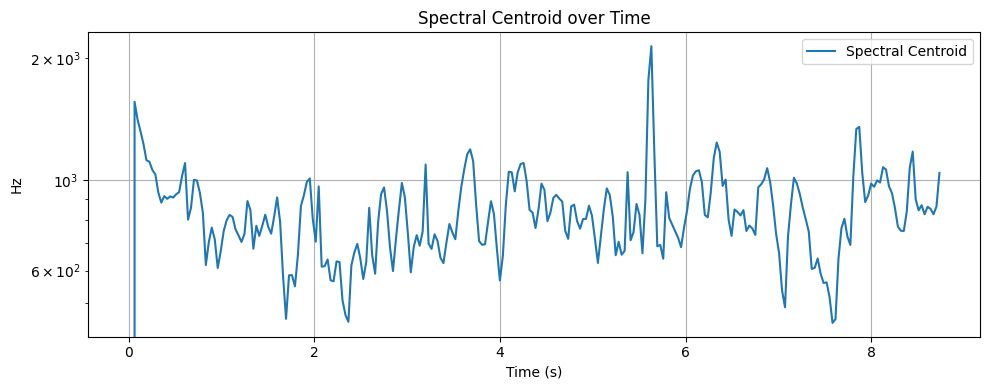

In [31]:
frames = range(len(centroid[0]))
t = librosa.frames_to_time(frames, sr=SAMPLING_RATE)

plt.figure(figsize=(10, 4))
plt.semilogy(t, centroid[0], label='Spectral Centroid')
plt.xlabel('Time (s)')
plt.ylabel('Hz')
plt.title('Spectral Centroid over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()